# Exploring the NHANES diabetes data

[DSLC stages]: EDA


You can conduct an EDA of the NHANES diabetes dataset in this document.

In [33]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')
ames_data = pd.read_csv('anes_data.csv')
dictionary = pd.read_csv('dictionary.csv', index_col=0)

train_time_data = pd.read_csv('train_time_data.csv')
val_time_data = pd.read_csv('val_time_data.csv')
test_time_data = pd.read_csv('test_time_data.csv')
dict_time_series = pd.read_csv('dict_time_series.csv', index_col=0)
                        
data_States = pd.read_csv('data_States.csv')
data_register = pd.read_csv('data_register.csv')
data_income = pd.read_csv('data_income.csv')
data_noVote = pd.read_csv('data_noVote.csv')

In [34]:
from scipy.stats import ttest_rel, t
import pandas as pd
import numpy as np

# Assuming train_data contains columns starting with "PRE_" and "POST_", and "weights"
pre_columns = [col for col in train_data.columns if col.startswith("PRE_")]
post_columns = [col for col in train_data.columns if col.startswith("POST_")]

# Match PRE and POST columns (ignoring "PRE_" and "POST_" prefixes)
pre_post_pairs = {
    pre: pre.replace("PRE_", "POST_") for pre in pre_columns if pre.replace("PRE_", "POST_") in post_columns
}

# Prepare a DataFrame to store test results
results = []

# Compare each PRE-POST pair
for pre_col, post_col in pre_post_pairs.items():
    pre_data = train_data[pre_col]
    post_data = train_data[post_col]
    weights = train_data['weights'].loc[pre_data.index]  # Align weights with data
    
    # Ensure equal length for paired testing
    paired_data = pd.DataFrame({
        "pre": pre_data,
        "post": post_data,
        "weights": weights
    }).dropna()
    
    pre_values = paired_data["pre"].astype(float)
    post_values = paired_data["post"].astype(float)
    weights = paired_data["weights"].astype(float)
    n = len(pre_values)  # Sample size
    
    # **Unweighted Tests**
    try:
        unweighted_t_stat, unweighted_p_value = ttest_rel(pre_values, post_values)
        unweighted_test_type = "t-test"
        
        # Calculate confidence intervals for unweighted test
        unweighted_mean_diff = post_values.mean() - pre_values.mean()
        unweighted_std_dev_diff = (post_values - pre_values).std()
        unweighted_se_diff = unweighted_std_dev_diff / np.sqrt(n)
        unweighted_t_critical = t.ppf(1 - 0.05 / 2, df=n - 1)
        unweighted_ci_lower = pre_values.mean() - unweighted_t_critical * unweighted_se_diff
        unweighted_ci_upper = pre_values.mean() + unweighted_t_critical * unweighted_se_diff
        
    except ValueError:
        # If t-test fails, default to Wilcoxon (non-parametric)
        unweighted_t_stat, unweighted_p_value = wilcoxon(pre_values, post_values)
        unweighted_test_type = "Wilcoxon"
        unweighted_ci_lower, unweighted_ci_upper = None, None  # CI not computed for Wilcoxon

    # **Weighted Tests**
    diff = post_values - pre_values
    weighted_mean_diff = np.sum(weights * diff) / np.sum(weights)
    weighted_var_diff = np.sum(weights * (diff - weighted_mean_diff) ** 2) / np.sum(weights)
    weighted_se_diff = np.sqrt(weighted_var_diff / n)  # Weighted standard error
    weighted_t_stat = weighted_mean_diff / weighted_se_diff
    df = n - 1  # Degrees of freedom
    pre_weighted_mean = (pre_values * weights).sum() / weights.sum(),
    post_weighted_mean = (post_values * weights).sum() / weights.sum()

    # Calculate p-value (two-tailed test)
    weighted_p_value = 2 * (1 - t.cdf(np.abs(weighted_t_stat), df))

    # Calculate confidence intervals for weighted test
    weighted_t_critical = t.ppf(1 - 0.05 / 2, df)
    weighted_ci_lower =  pre_weighted_mean - weighted_t_critical * weighted_se_diff
    weighted_ci_upper =  pre_weighted_mean + weighted_t_critical * weighted_se_diff

    # Store results
    results.append({
        "Variable": pre_col.replace("PRE_", ""),
        "PRE_Mean_Unweighted": pre_values.mean(),
        "POST_Mean_Unweighted": post_values.mean(),
        "PRE_Mean_Weighted":  pre_weighted_mean,
        "POST_Mean_Weighted":  post_weighted_mean,
        "Unweighted_Test_Type": unweighted_test_type,
        "Unweighted_Mean_Difference": unweighted_mean_diff,
        "Unweighted_CI_Lower": unweighted_ci_lower,
        "Unweighted_CI_Upper": unweighted_ci_upper,
        "Unweighted_T_Statistic": unweighted_t_stat,
        "Unweighted_P_Value": unweighted_p_value,
        "Weighted_Mean_Difference": weighted_mean_diff,
        "Weighted_CI_Lower": weighted_ci_lower,
        "Weighted_CI_Upper": weighted_ci_upper,
        "Weighted_T_Statistic": weighted_t_stat,
        "Weighted_P_Value": weighted_p_value
    })

# Convert results to a DataFrame
comparison_results = pd.DataFrame(results)

# Display significant changes (p-value < 0.05 for weighted and unweighted)
significant_unweighted = comparison_results[comparison_results["Unweighted_P_Value"] < 0.05]
significant_weighted = comparison_results[comparison_results["Weighted_P_Value"] < 0.05]

print("All variables considered\n", comparison_results["Variable"])
print()

print("Significant Changes from Pre to Post (Unweighted):")
print(significant_unweighted[['Variable','PRE_Mean_Unweighted','POST_Mean_Unweighted','Unweighted_P_Value']])

print("\nSignificant Changes from Pre to Post (Weighted):")
print(significant_weighted[['Variable','PRE_Mean_Weighted','POST_Mean_Weighted','Weighted_P_Value']])


All variables considered
 0                    ThermoBiden
1                    ThermoTrump
2                   ThermoHarris
3                    ThermoPence
4                   VoteAccuracy
5     VotePresident_Donald Trump
6     VotePresident_Jo Jorgensen
7    VotePresident_Howie Hawkins
Name: Variable, dtype: object

Significant Changes from Pre to Post (Unweighted):
                      Variable  PRE_Mean_Unweighted  POST_Mean_Unweighted  \
0                  ThermoBiden            49.048482             51.159248   
1                  ThermoTrump            40.678054             39.785197   
2                 ThermoHarris            47.819186             49.453416   
3                  ThermoPence            44.384231             47.273292   
4                 VoteAccuracy             3.074534              2.289683   
5   VotePresident_Donald Trump             0.449275              0.493444   
6   VotePresident_Jo Jorgensen             0.030538              0.010870   
7  VotePresi

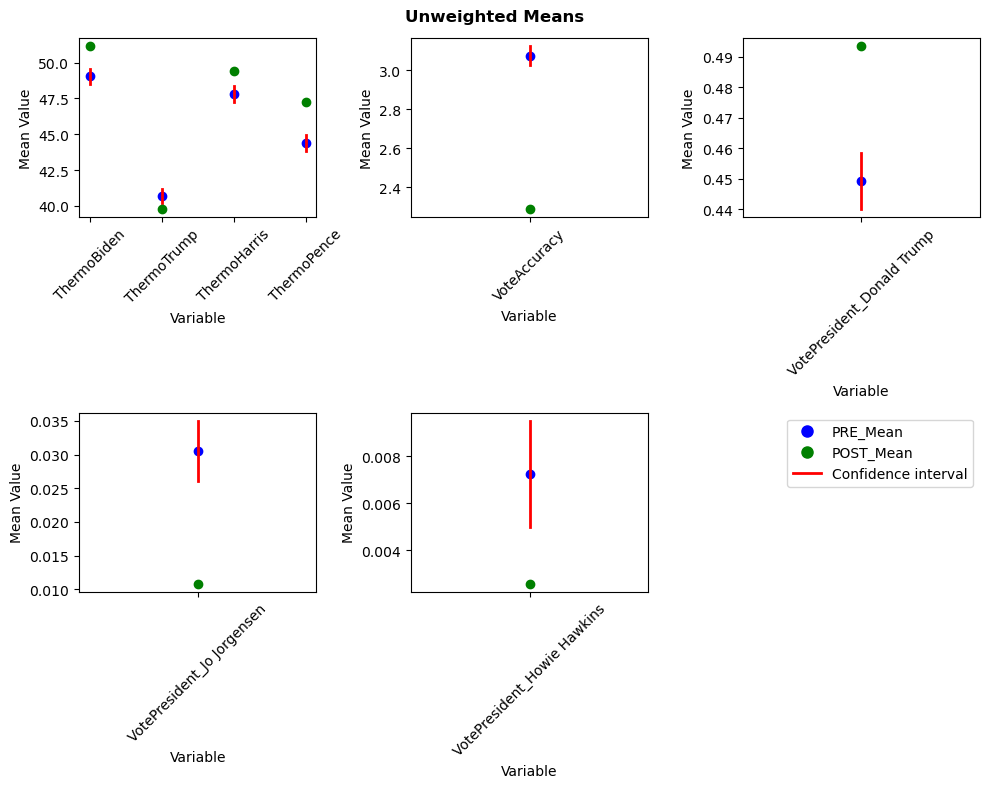

In [35]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(unweighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = unweighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][4], unweighted_data["Unweighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, unweighted_data["POST_Mean_Unweighted"][4], 'o', color='green', label='POST_Mean')


# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+5], unweighted_data["Unweighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")
    
# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+6], unweighted_data["Unweighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+7], unweighted_data["Unweighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Unweighted Means', fontweight='bold')
plt.tight_layout()
plt.show()

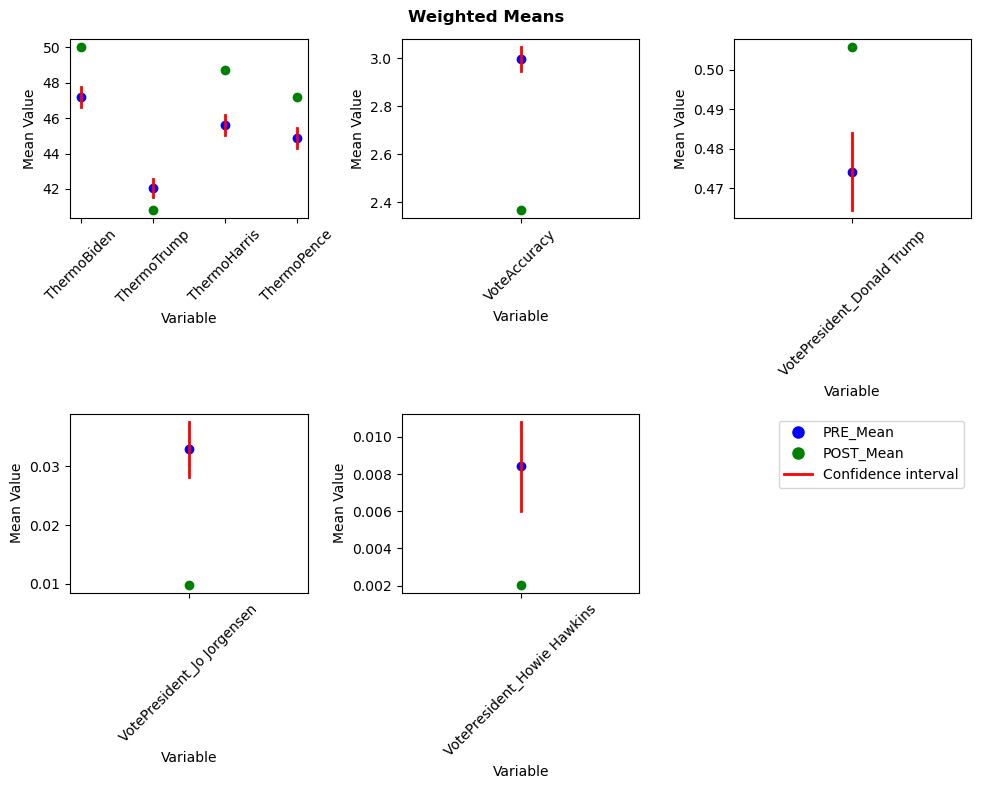

In [36]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(weighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i], weighted_data["Weighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = weighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, weighted_data["PRE_Mean_Weighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][4], weighted_data["Weighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, weighted_data["POST_Mean_Weighted"][4], 'o', color='green', label='POST_Mean')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+5], weighted_data["Weighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+6], weighted_data["Weighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+7], weighted_data["Weighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)


# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Weighted Means', fontweight='bold')
plt.tight_layout()
plt.show()

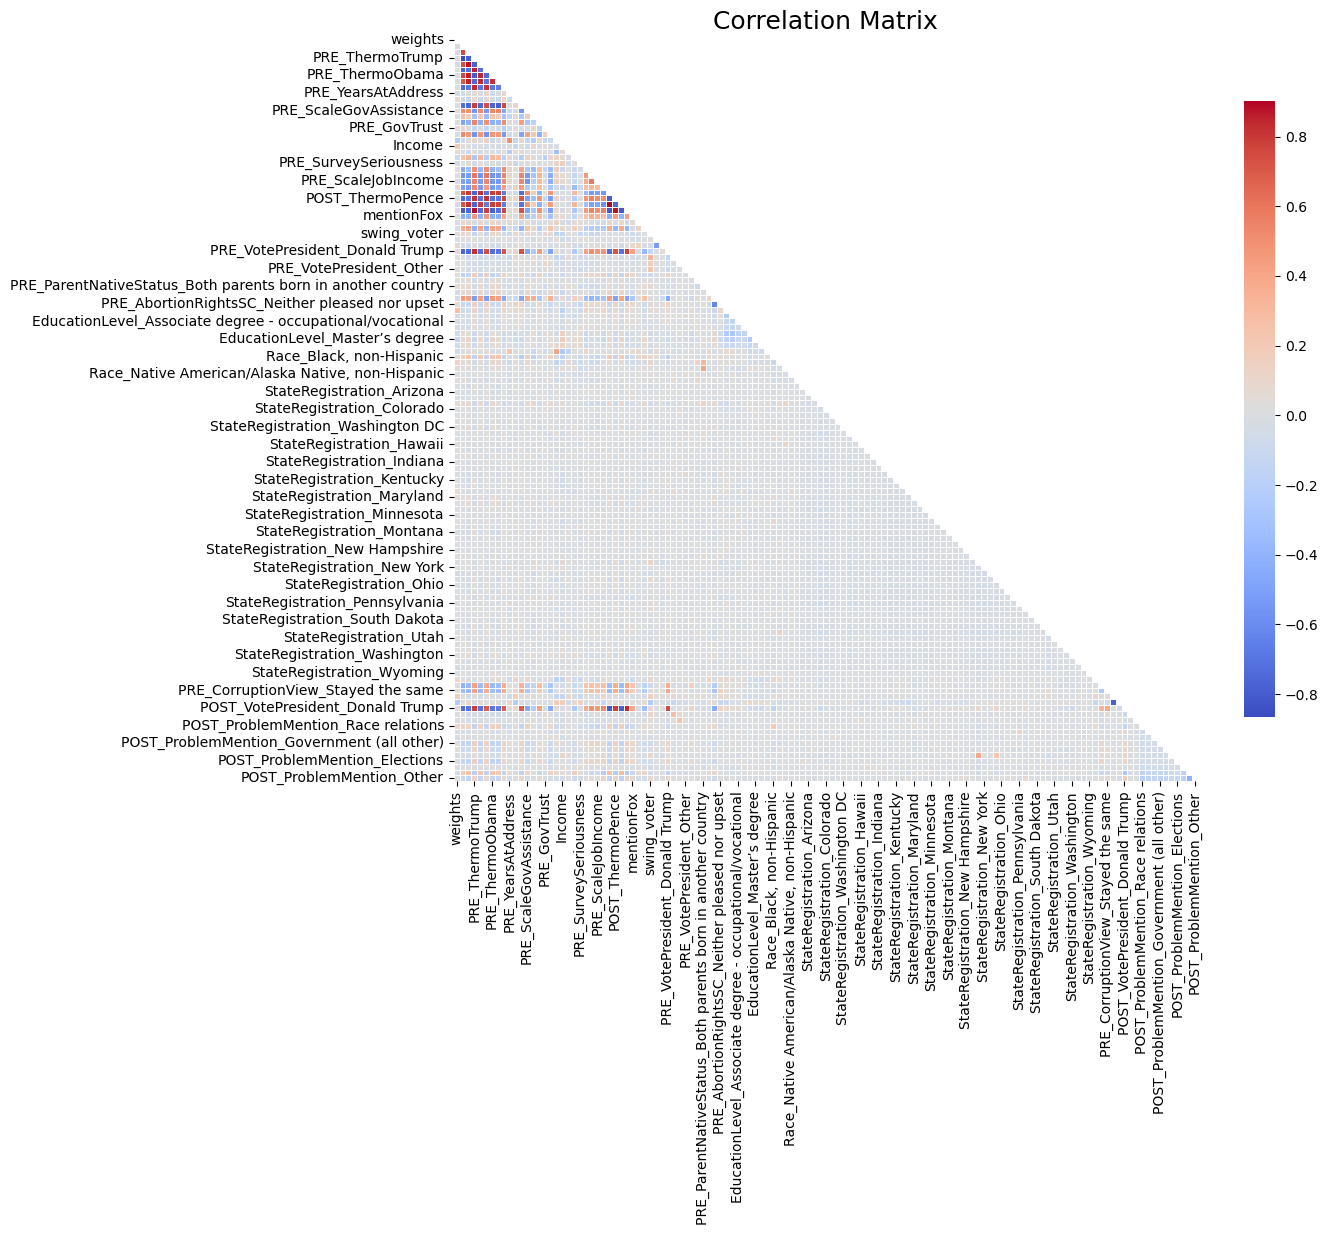

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix =  train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('Correlation Matrix Heat Map')
plt.show()

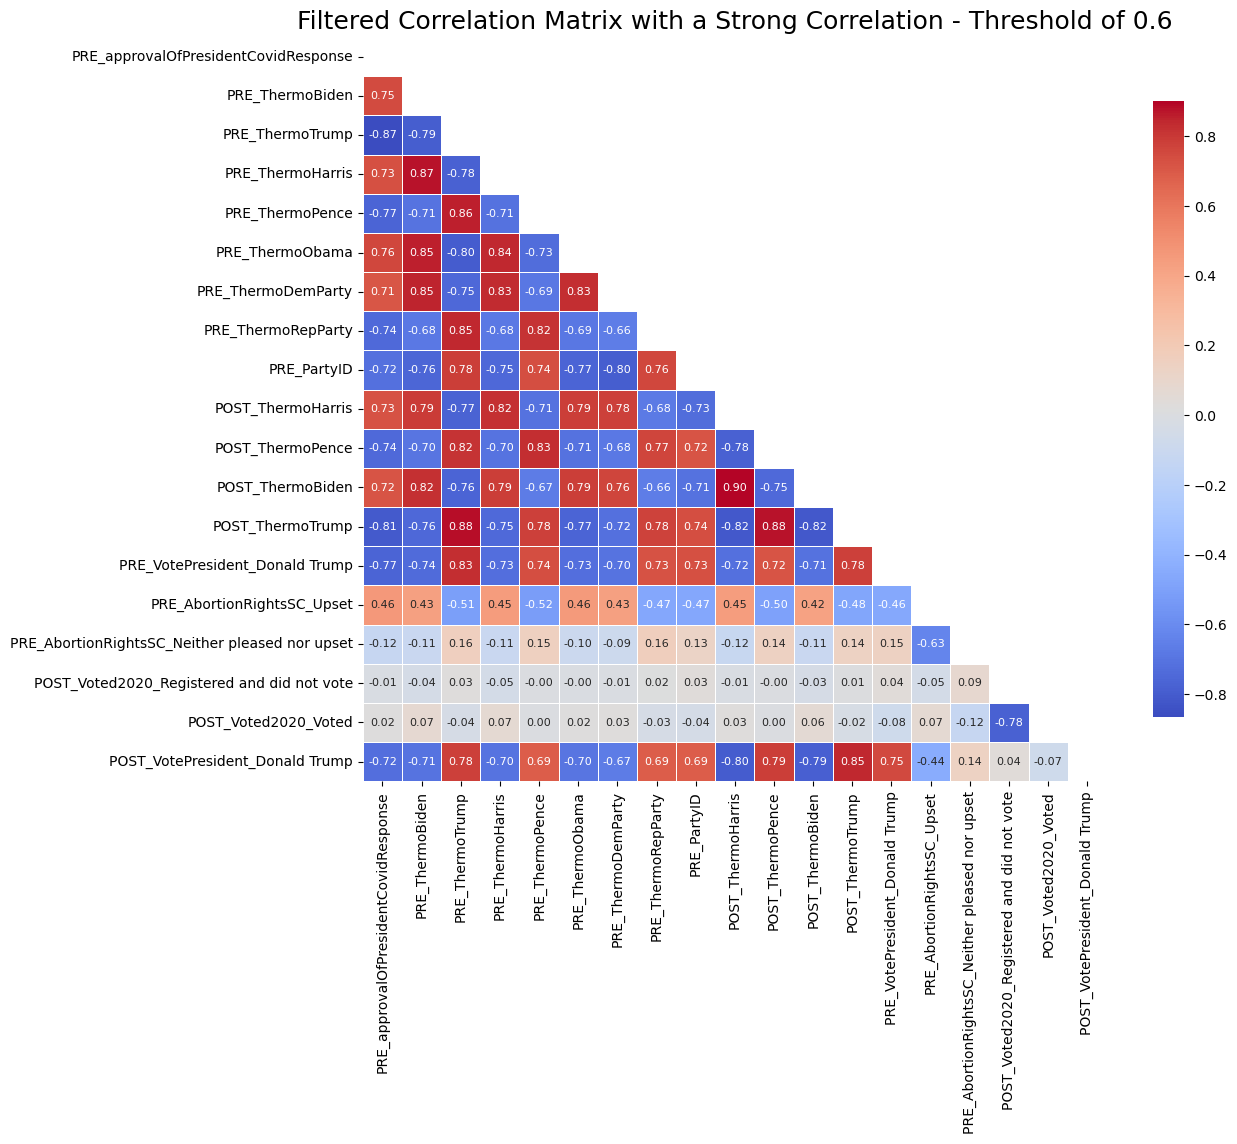

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.6

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=True,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

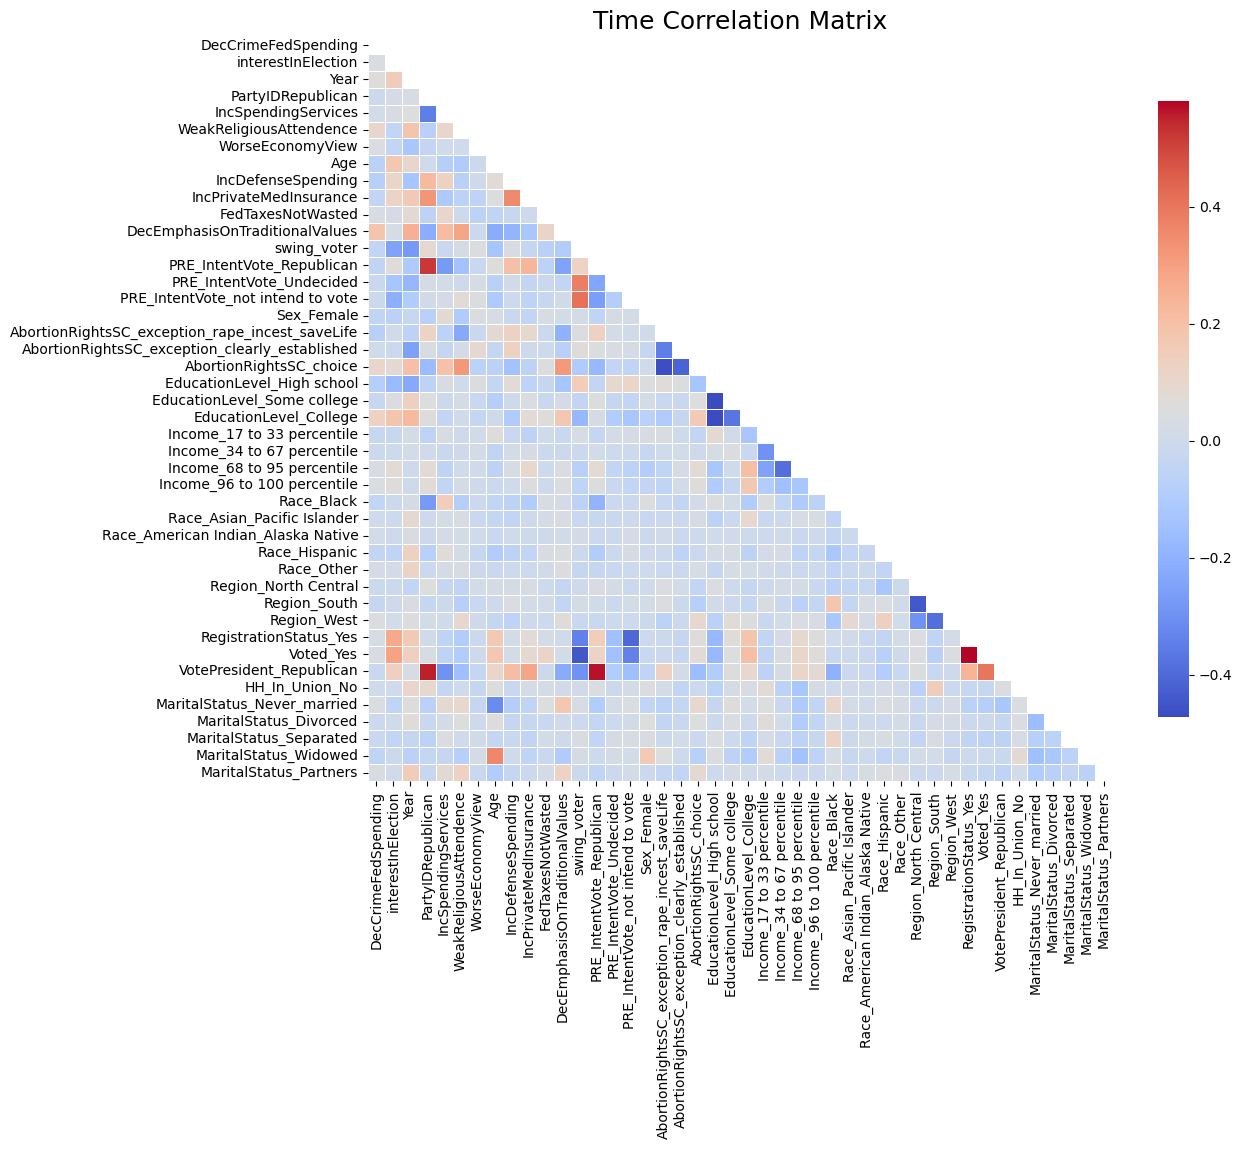

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix_time =  train_time_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_time, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix_time, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Time Correlation Matrix', fontsize=18)
plt.savefig('Time Correlation Matrix Heat Map')
plt.show()


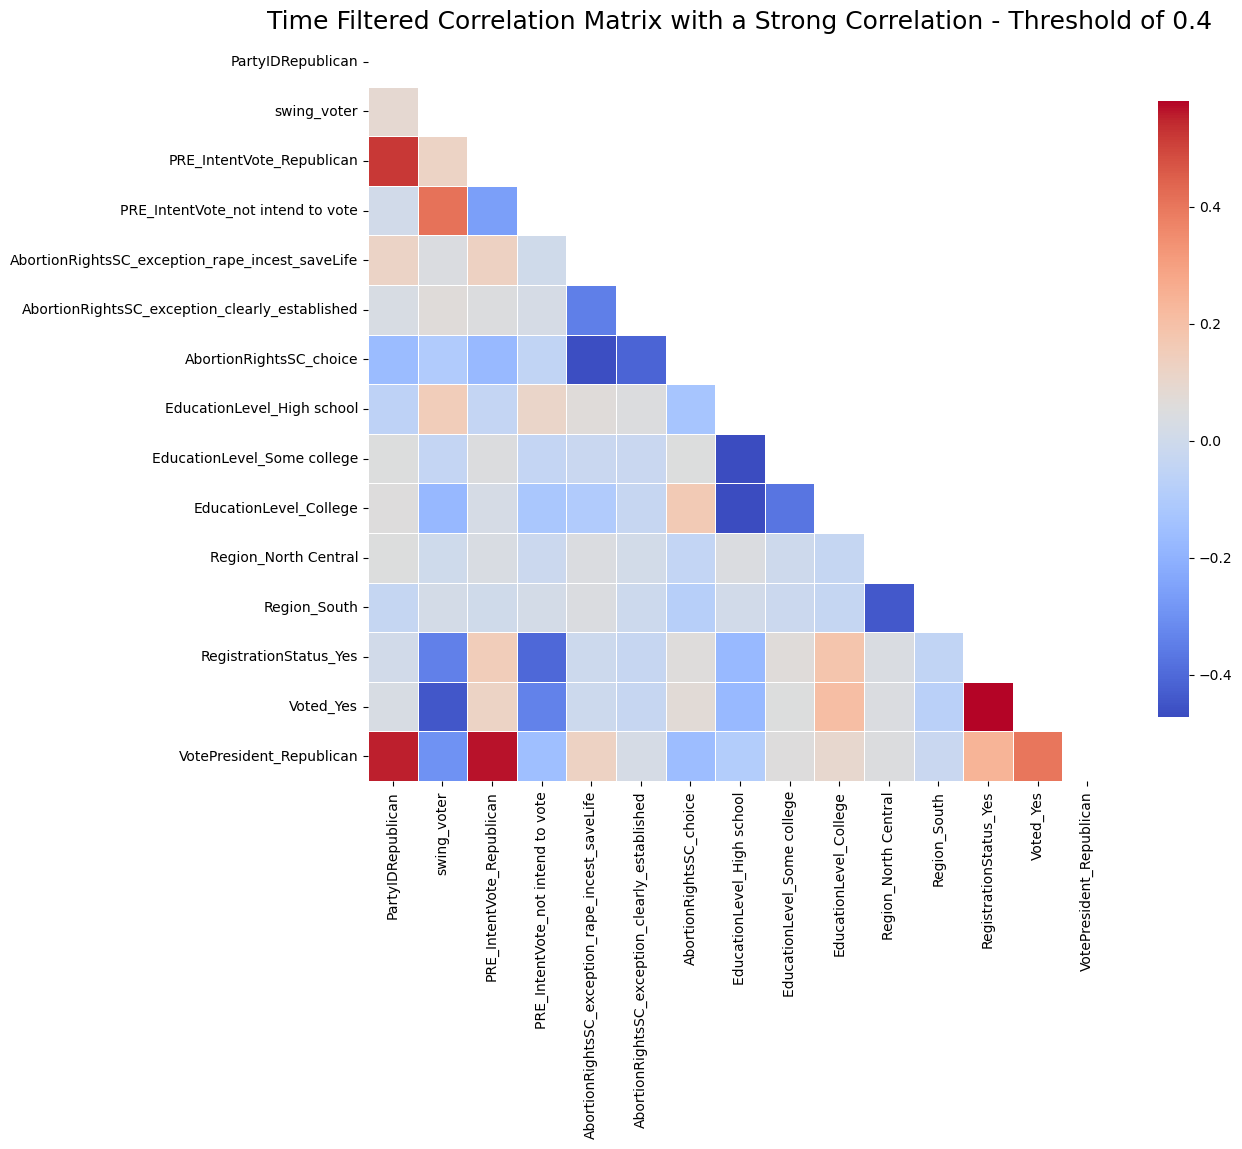

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.4

corr = correlation_matrix_time.copy()

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix_time.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = corr.loc[filtered_correlation_matrix.index, filtered_correlation_matrix.columns]

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=False,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Time Filtered Correlation Matrix with a Strong Correlation - Threshold of ' + str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()


In [41]:
import importlib
# Import the function
from functions import explore_data_helper

# Reload the module to reflect any updates
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_data = [explore_data_helper.perturb_dataframe(train_data) for i in range(100)]

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.44313142 0.78151734 4.27780738 ... 4.2880924  4.50756246 1.22957033]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 72.5133626  108.79860312  63.781725   ...  59.45501947  46.71293319
   9.16003519]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.59335243 0.81270135 3.97123515 ... 0.46428956 4.50932842 4.07665473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -6.10663804  56.35506443 105.33338758 ...  68.48407392   5.43635799
  47.46945604]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.54498814 4.15774706 2.22258572 ... 3.95503896 2.72228685 4.43249649]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 12.9904933   72.01218515  87.76379251 ... 103.63771464 -13.65867821
  52.84473325]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.83185864 4.09183382 2.63114167 ... 0.55094413 1.18499066 3.71243486]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 81.50260456  28.16229215  65.77100865 ... 105.07102841 100.68505141
  51.28118059]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.24745366 3.48529159 4.5416404  ... 4.5801131  1.59287811 4.13201373]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 85.37251608 -12.32819983  12.783639   ...  14.59337389  75.16043536
   4.15917899]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.47805607 1.06524269 1.76277801 ... 1.27158346 2.22507813 2.23506714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19.76326767 68.26553076  0.68524004 ... 91.42902505 34.16479916
 83.52280723]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90577883 3.86980298 4.22512698 ... 0.35368368 3.73346109 3.408599  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[75.7993596  54.16999365 75.63946351 ... 69.64542546 83.87227722
 70.59723257]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.4903118  4.16680298 3.4152911  ... 1.43760467 3.43541666 1.64179983]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[73.0567946  65.33084133 46.32477309 ... -1.30884696 96.45104618
 38.63633092]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6957527  4.60820772 4.20414298 ... 0.7806965  3.78731211 0.56551666]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -8.87566988  26.11715395   4.00305961 ...  12.0204466  107.29616392
   9.65020711]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.15718597  0.97132812 -0.03737949 ...  0.93616123 -0.19612595
  0.0273635 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.794101    0.81039069 -0.09384265 ...  0.21298722 -0.09136156
  0.05412822]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.11530245  0.89604151  0.044799   ...  0.16685022  0.0909599
  1.17216155]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.15337698 -0.12683565  0.05060588 ... -0.19713271 -0.18118017
  0.92298205]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.20436535 3.95102128 3.91095334 ... 4.18732296 1.03950299 4.64596519]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[64.25278987  7.37400375 31.93904623 ... 27.12914192 73.85225325
 39.06129515]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90439742 4.35421504 3.94439736 ... 1.4016426  1.50342798 4.06913114]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[84.06379785 71.07256546 16.93629978 ... 34.68115025 -9.57305439
 20.90058881]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.31070037 3.69863277 2.12290473 ... 3.85376412 2.90166088 3.97812379]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[18.84651294 12.260203   28.42054805 ... 76.46283981  0.60146313
 64.65536314]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.87651455 1.20635809 4.11077949 ... 0.57628256 3.28752172 1.43434459]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[87.8796376  95.3646952  72.78528421 ... 74.43054035 46.32223856
 56.99052924]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.13915048 3.87923899 0.78421046 ... 4.05221989 0.62121053 1.39863601]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 29.02646935  94.68146246 -15.96151499 ...  46.66895719 100.38298455
  11.80917447]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.06557215 3.67698063 4.27999971 ... 0.88919005 4.41516616 0.41760244]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[11.98966431  9.41702609 89.66028089 ... 84.08153579 65.14717859
 55.3726357 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.09979153 3.74260521 3.6438132  ... 0.80077295 3.77692783 4.3597916 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[89.46260408 64.19882993  1.70992582 ... 19.22977448 22.87212851
 56.48074936]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.88712046 3.42289549 1.16124661 ... 4.0077563  3.58227968 0.86825809]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -7.8045375  -15.87383662  60.39021559 ...  97.87934632  90.76968594
  44.98356304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.76899112 3.68172144 3.91530836 ... 3.84127497 2.38626744 0.5183167 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.43854425 85.86525403 64.82881294 ... 15.20161371 31.06263105
 85.57291029]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.6390911  4.51893123 4.14917671 ... 3.26265862 3.67380303 3.89034513]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-11.90610678  -3.24093087  94.14125245 ...   7.50014797  -3.33607045
  29.77810732]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.27660236 2.00947273 2.82575715 ... 2.98324962 2.42110855 2.04589507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[113.52821502  35.62751028 104.35589802 ...  59.2637441   51.67958703
  11.51402224]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.60313347 0.77835774 3.91461531 ... 4.61988904 3.40915741 0.93318074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[100.54940006 116.29940074 -10.76291667 ...  71.76471265  60.14244262
  60.1572185 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.22813006 3.37529378 4.6506337  ... 2.50812732 3.46217531 3.7023542 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 58.53280038  71.98024239  42.74878256 ...  48.11371635  13.90102561
 -14.04881469]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.42385736 2.61948305 1.1568392  ... 0.89976746 1.16978356 0.59731146]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[54.33749033 61.40610035 50.431977   ... 46.38690178 64.91232762
 83.67452464]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.36013865 4.54482638 3.90007238 ... 0.71562673 1.13566019 4.5030728 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[94.21657171 72.14751418 95.61511465 ... 78.49084131 68.26099678
 71.30065436]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.61727063 1.10152218 3.76991246 ... 4.36887728 3.75263265 4.29441246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 45.71372726  84.43739482  96.26536199 ...   7.67022443 103.18667641
   3.63292426]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.61614408 1.35577119 2.01767875 ... 3.94217388 3.76105648 1.22890816]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[70.8251744  51.15284296 78.18844787 ... 25.40286195 41.05024206
 68.02712849]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.53514624 1.4462917  3.63677985 ... 1.89866625 3.6262945  3.80738567]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 71.68480365  75.24331978  75.10803824 ... 100.29151153   4.58339456
  -9.53753378]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.51971786 0.89723408 4.45560184 ... 1.40373717 3.39406323 4.04882298]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[54.58713765 16.42345781  2.84822927 ... 98.88838074 29.59993056
 95.11913119]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.50859149 4.28614856 2.32843075 ... 3.62849607 4.23680048 3.09016961]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[47.4082777   0.45542737 46.97553973 ... 95.96809708 90.02623258
 38.25511695]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.920725   3.71084595 0.64445387 ... 3.72495751 3.79723999 3.83190458]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 94.1353068   95.24353423  30.92651119 ... 100.97001402  91.23551842
   0.70499042]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.4216062  3.46738843 0.9013753  ... 0.6992929  4.29799546 3.99482876]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[106.19500314  70.63550023  96.3302262  ...  35.00227628  87.74397249
  73.32575543]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.94275543 3.80826918 0.88412042 ... 3.81872982 3.9405791  4.16821411]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -6.71667192  60.80462764 101.17452281 ...  69.08046143  72.31617264
  88.81071822]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.3369506  3.5209111  4.22672677 ... 3.59056978 3.40022578 1.93003531]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[55.90766862 62.1377187   4.65399268 ... -6.28194244 61.07511395
 64.69910449]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.42714831 4.23511955 3.6801564  ... 3.70412616 4.6492224  4.47120676]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 62.41884464 101.01787324   8.24518804 ...  -7.66452989  94.08963179
  55.72805763]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.24208702 2.06369579 4.01435099 ... 3.5493376  0.97494787 3.83224314]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[89.83273223 12.48924202 87.17123209 ... 71.15779357 88.48664589
 -8.68672737]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.6203943  3.55753418 3.36316286 ... 2.36992071 4.61703467 0.58667994]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 52.64570687  15.1034296   16.72632093 ...  64.74960873 112.1280885
  -0.99320024]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\O

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.5602478  4.36952496 4.2033107  ... 2.42811476 3.66516598 4.14897588]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.52274504  73.54261499   9.92176625 ...   4.29406565 -16.4776519
  21.65278359]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\O

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.97394927 2.26243296 3.40649648 ... 4.39108713 1.91228551 4.16447494]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[43.09765461 95.84101981 97.5006795  ... 25.22060395 31.02279584
 92.10834874]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.45886792 3.43243297 3.41068337 ... 4.23536089 4.22047936 2.83147262]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[45.49301441 49.22154071  8.7015524  ... 85.75965352 56.12985122
 -0.87381813]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.13635077 3.87921327 0.46401333 ... 4.31099678 1.31913104 4.00209877]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[111.85305929 -10.87198162  45.70503084 ...  63.23955368  89.10496185
   9.07225407]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.83377455 0.60503775 4.00020655 ... 2.8258122  3.76648215 4.34588253]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 64.84783608 107.57514721  56.2391145  ...  57.92138025   0.50376752
 107.180099  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.15684414 4.60798701 3.43550538 ... 3.48356992 4.21180969 3.40908407]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[76.14678518 44.02247165 29.73252602 ... 44.43538684 83.72986891
 28.15986473]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.70873907 1.64077462 4.52893673 ... 3.81309423 1.52607581 3.6086038 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[101.60325896  21.53923513  91.70029481 ...  38.71400648  72.76855165
  54.31387168]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.26711402 3.813371   0.50064846 ... 4.36384968 1.53595924 2.23426997]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[39.03327035 63.94461846 62.55137683 ... 70.16031141 61.47680363
 57.44514691]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.23342584 4.46565457 3.86710752 ... 3.37231977 4.57338539 3.52656367]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.33766851  40.53414278   9.17915354 ...  25.88734396  61.81316877
  62.31409636]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.16772878 0.79736057 3.13240226 ... 3.3910642  1.25388708 1.58346966]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25.12572158 75.03991661  9.44597046 ... 77.11879432 53.04174682
 46.31565866]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.69163762 2.26489355 1.61906434 ... 1.80316267 1.59744551 4.03006111]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[48.55409159  3.36456708 23.45750537 ... 30.19501503 60.00481005
 16.92775606]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.49540177 1.25880579 3.97373923 ... 3.95176766 3.23300403 4.33741707]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.10180977 -8.5791199  65.88501602 ... 71.35562392 92.03808747
 85.83035547]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.20967022 3.38395615 3.79264703 ... 4.33839024 0.55288842 3.73802251]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[113.87607294  62.39497965  64.91709903 ...  46.04378527  67.49242253
  -8.51540051]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.3652039  1.01356253 3.39650432 ... 0.4055211  4.00102146 1.72880273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[104.48901442  48.82971647  28.60762442 ...  -9.67201361  13.25222924
  80.89043615]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.36912653 3.45875078 1.5366838  ... 3.40674003 4.48668686 4.30891094]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[14.91911317 31.12448183 74.1940958  ... -3.61581262 89.32224206
 -4.7449633 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.62157738 4.47079858 4.18207777 ... 4.35159941 2.48220931 0.4608594 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 77.915345    36.24307151 -17.03361578 ...  74.03147439  50.46459593
  57.29369808]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.78230234 3.72716944 4.53928135 ... 4.48056744 3.81763617 1.05096161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[50.18469098 94.12489249 87.06538439 ... 14.16628839 64.53708158
 25.71426209]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.74902001 4.03084686 3.63932864 ... 2.41395765 4.07977801 1.37782607]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[36.10045989 14.23198557 91.71991454 ... -9.75202397 77.67094405
 67.99581794]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.49859258 1.97430044 4.0147262  ... 3.34974502 3.49443093 3.66051665]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[72.53547369 -1.63537058 62.31264334 ... 95.70659461 92.49146396
 67.38573754]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.5625684  3.70233661 1.5037207  ... 0.4117684  1.46728863 0.97683412]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[102.38548819  94.86583383  -0.33213764 ...  76.6208336    3.32777189
  38.43300477]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.12845493 3.87012705 4.35555959 ... 1.05439168 3.65621213 3.83642649]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[17.31854746 10.58777631 77.44495253 ... 45.06825781 89.24367506
  4.92504275]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8756855  0.43309713 4.31758427 ... 4.64101545 4.06055246 1.30381131]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[49.0785344  76.59069087 49.55117685 ... 16.05202334 89.43456836
 66.0361651 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.13297155 3.86908646 2.2839993  ... 3.77532673 0.89626251 4.15477886]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[74.36452244 15.20679281 15.50360771 ... 31.3423288   5.90940357
 27.61912917]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.39446469 3.44852175 0.75050324 ... 3.00558219 4.50150049 1.57591395]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.57688486 55.06337811 75.79215007 ...  8.14322006 71.85343449
 72.6847006 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.50739428 4.38245783 0.71473746 ... 1.46038451 3.7350877  3.82244023]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 82.61927623   7.45166792  27.90900528 ...  60.7201102   34.18299379
 -12.24251644]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.06780734 3.18743884 4.2846727  ... 3.4287961  1.62019049 1.20087635]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  3.98717353  -9.04277876  82.46876955 ...  21.40628033  89.13884388
 101.09529034]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.05515509 4.24565279 4.34283166 ... 4.52520308 1.40214098 4.4245324 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13.47562353 75.90309131 71.62000287 ... 98.64586988 73.9716721
 80.0176142 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDriv

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.50852314 4.62463458 2.44421991 ... 1.03586612 1.61513164 4.33557519]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 16.42574211   1.66840691  78.76147196 ...  78.01198723  34.22476537
 -10.79091851]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.06344163 3.64232713 4.40073708 ... 3.45386859 1.57164626 4.01440787]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[77.2186027  98.42699102 65.65484321 ... 48.00101415 64.62305361
 14.36417175]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.37069499 0.56494667 2.21930814 ... 3.97061217 2.58371631 4.21409871]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[117.06116443   0.70287061   3.36952201 ...  14.83401296  66.95091513
  71.06994601]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90570334 3.45932697 3.49717548 ... 2.54890966 3.59241633 4.07368119]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[47.28401044 54.6890015  56.29525864 ... 19.56561978 33.23933623
 63.44865012]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.59968581 3.94234502 1.44028652 ... 3.79866875 3.91298228 0.91538368]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[81.55911352 43.53239145 81.49760117 ... 96.74436819 32.58618904
 -4.38747287]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.40750606 4.2294689  1.27888728 ... 4.53831112 1.83495315 4.41092744]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[83.16794002 14.41115177 87.54024193 ... 71.31247911  3.23238253
 12.43886227]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.3639854  0.42602288 3.67934859 ... 4.111487   1.12576194 4.33957124]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[69.9803387  55.23782112 78.42986845 ... 83.05317356 79.39836763
 60.32115795]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.45017537 4.42784366 3.5240012  ... 3.45325145 3.93374294 0.3792816 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 82.36323696 104.82754996  -3.39377797 ... 106.73621339  56.03218707
  25.18023092]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.0289344  2.21686124 4.33561122 ... 3.41416079 4.04468015 1.9131176 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -8.19982188  98.05566216  57.13281419 ...  14.48597792  29.35916159
 104.20160426]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.48561125 3.55873501 0.58663262 ... 3.6852578  0.53931297 4.51615707]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 23.8145792   29.93990454  63.07287949 ...  64.2139126   17.15592005
 107.15646154]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.5848396  0.41658807 1.59509162 ... 4.44249891 0.62905118 4.07037522]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 97.40089628  83.04658462  91.04268345 ... -14.58064407  76.73766694
  46.04299233]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.92213376 3.47016586 3.63634428 ... 4.57030813 3.99796205 2.51083452]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 89.72841855  86.60223766  59.066097   ...  42.92054718 111.30088805
  79.10094439]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.29710957 4.0132434  3.59212015 ... 3.7095905  1.55216189 4.27211002]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 68.07483027  74.70146286 113.02885207 ...  27.7483438   42.68662504
  53.67960287]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.66714127 1.35362728 0.61096281 ... 2.10210419 3.44668745 4.55729536]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[53.94524491 97.42463309 47.16596773 ... 66.17167442 48.60109823
 65.9486607 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.99283065 1.85323003 1.10440946 ... 1.53042492 2.53060296 3.68723284]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 50.56679066 -15.47861531 105.90094519 ... 117.11762637 -12.27188182
  72.49500214]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.95385834 1.2883872  1.7535874  ... 1.10576564 4.64304398 3.33104018]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[96.41655202 57.35271976 82.38009496 ... 81.22775233 49.04524963
 16.86200216]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.79819122 1.63294746 4.02433677 ... 0.58952217 1.88401584 2.26984376]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 36.06358745 -12.70828398  72.11305246 ...  37.15342747  54.32174045
  81.52546739]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.63592031 4.46530148 1.35262062 ... 3.69726878 4.34525967 4.08265792]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[29.91748904 14.51409448 23.15107424 ... 72.08577291 73.82610782
 21.00920717]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0635673  4.48127325 3.6823411  ... 3.52559218 2.46928682 3.38964272]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 99.0465206  107.58374358   3.40231108 ...  16.05224489  78.27834267
  69.51393532]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.56307656 3.49329233 4.12578348 ... 4.41641707 1.61307038 3.57759825]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 55.85162016 -10.95179134  51.65292729 ...  63.84341405  59.99125029
  98.45351819]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.30263613 1.14858986 3.75230728 ... 3.93696393 4.2988746  3.51145749]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 11.91332093  -1.02614389  57.91177159 ...  86.35607224  20.31464456
 -16.0455708 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.57486584 1.19460886 4.57492282 ... 4.45196208 4.18801197 0.66876051]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[15.25497387 72.31094318 59.82455038 ... 89.90378497 70.80956908
 56.62319265]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.64317656 4.21245253 1.59758817 ... 3.41532382 3.53000561 2.42593018]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[31.49454155  0.12964055 -8.652601   ... 29.76937101 68.56649656
  6.89648613]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.08977479 3.85500136 4.07530286 ... 4.20647328 4.11547058 0.61110271]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 74.71176135  11.70230646  48.9104527  ...  79.03240858 -13.72563516
  88.77409056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.08851245 2.98973698 4.18740718 ... 0.55400707 0.38539331 0.44735803]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[43.70976763 64.35757474 71.26428948 ... 99.07999828 75.80964516
 81.11392162]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.51781965 1.58652224 1.51759011 ... 4.29164586 2.98017248 0.63474844]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[96.01706147 87.57114771 23.29785645 ... 79.72894701 83.45246513
 -2.66109634]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.40078436 4.26049713 4.5137365  ... 1.38673065 2.44694122 1.66684736]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[72.85911529 30.4685811  64.36589906 ...  9.62898526 52.85492189
 41.28361833]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.42108438 2.38302942 1.35877462 ... 3.43332806 3.35077957 4.14294745]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[105.77304873  22.77823421  46.92534769 ...   4.23318444   8.12830669
  86.45851894]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.43685332 0.99508342 1.52506356 ... 1.46201795 3.59585119 0.87145744]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 55.71626368  58.62164178  66.07852158 ... -15.75075302  31.07581361
  47.7068586 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.16090412 3.89615725 3.39709832 ... 4.04490547 4.39819352 2.12488847]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[46.628848   59.9540763  53.36337496 ...  3.0962388  -8.36236094
 55.75893934]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.33348922 2.21719118 4.53627275 ... 0.74431558 4.51089808 1.07026028]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 83.04925522  38.80393778  17.07230388 ... 112.17283489  11.0329835
 -15.41429713]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\O

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.96035174 3.53660312 4.64240422 ... 0.37791787 4.46502859 1.43700372]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13.36734148 74.88210824 10.27566666 ... 35.50584727 73.97890109
  2.36044184]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.42133431 3.73462042 2.73256774 ... 0.95027974 4.19074014 1.44002117]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.61852376  9.16211785  6.50083653 ... 11.19854923  2.44162678
 90.6111914 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDri

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.03285068 1.01672604 1.45453823 ... 2.31132477 1.62438107 4.46633324]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.76448     26.6907165   73.83967783 ...  82.86359267 -12.78865058
  78.37172592]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.58302934 4.27529213 3.06925623 ... 3.56995322 4.25900792 3.4718479 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 90.87627397   7.39343118 -11.65658842 ...   6.85499135  78.72729884
 115.68454026]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
C:\Users\15184\

In [42]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_means = train_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_means = []

for perturbed_df in perturbed_data:
    perturbed_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")


Columns with significant differences (p-value < 0.05):
interviewMode_Telephone: p-value = 0.029221658396014035
PRE_VotePresident_Howie Hawkins: p-value = 0.0004941149580315443
PRE_VotePresident_Other: p-value = 0.002197813754976918
Race_Native American/Alaska Native, non-Hispanic: p-value = 0.04440923802239929
StateRegistration_Alaska: p-value = 1.7840342207202487e-20
StateRegistration_Arizona: p-value = 0.027006635811401485
StateRegistration_Arkansas: p-value = 0.0002965639965245341
StateRegistration_Colorado: p-value = 0.026192616454172257
StateRegistration_Connecticut: p-value = 0.0017841434727791736
StateRegistration_Delaware: p-value = 2.932769556375424e-10
StateRegistration_Washington DC: p-value = 1.3002124936163207e-05
StateRegistration_Hawaii: p-value = 3.705493247235145e-06
StateRegistration_Idaho: p-value = 0.003156736766042524
StateRegistration_Iowa: p-value = 0.0019739114669583106
StateRegistration_Kansas: p-value = 0.011863797148299288
StateRegistration_Kentucky: p-value 

In [43]:
p_values

{'weights': 0.9986866609253194,
 'PRE_approvalOfPresidentCovidResponse': 0.9987369596913426,
 'PRE_ThermoBiden': 0.9985773517470434,
 'PRE_ThermoTrump': 0.9986511077148572,
 'PRE_ThermoHarris': 0.9986655006686297,
 'PRE_ThermoPence': 0.998785810908253,
 'PRE_ThermoObama': 0.9986737285876964,
 'PRE_ThermoDemParty': 0.998741721574171,
 'PRE_ThermoRepParty': 0.9986718382279594,
 'PRE_YearsAtAddress': 0.99876291181019,
 'PRE_SummaryVoteDutyChoice': 0.9987118874152168,
 'PRE_PartyID': 0.9987129778771269,
 'PRE_ScaleGovAssistance': 0.9986356792581533,
 'PRE_religionImportance': 0.9985200752140868,
 'PRE_CountryDirection': 0.9986371229481914,
 'PRE_GovTrust': 0.9986188768905718,
 'PRE_EconomyView': 0.9986908704234689,
 'Age': 0.9986387496783622,
 'Income': 0.9984608476393795,
 'HouseholdChildren': 0.9988098421782098,
 'PRE_VoteAccuracy': 0.9985904286343028,
 'PRE_SurveySeriousness': 0.9987202141684419,
 'PRE_ScaleDefenseSpending': 0.9986308312780898,
 'PRE_ScaleMedInsurance': 0.99856883810586

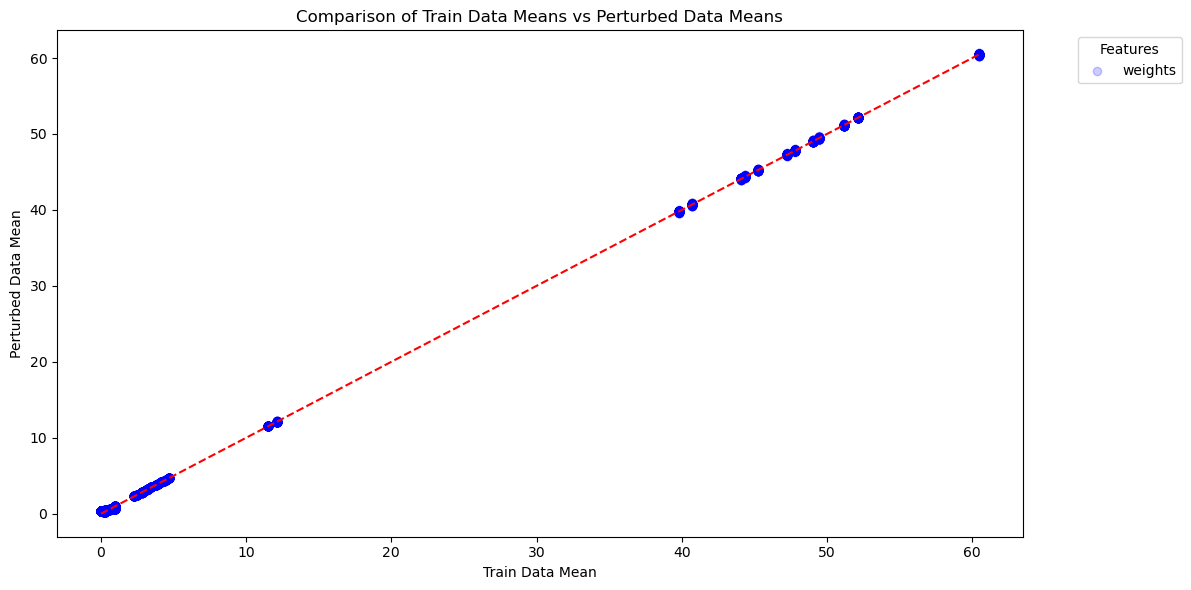

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of means for perturbed data to a DataFrame
perturbed_means_df = pd.DataFrame(perturbed_means)

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot of perturbed means (y) vs train means (x)
for i, feature in enumerate(train_means.index):
    ax.scatter(np.repeat(train_means[feature], len(perturbed_means)), perturbed_means_df[feature].values, 
               color='blue', alpha=0.2, label=f'{feature}' if i == 0 else "")
    
# Add a line for perfect agreement (y = x)
plt.plot([min(train_means), max(train_means)],
         [min(train_means), max(train_means)], color='r', linestyle='--')

# Add labels and title
ax.set_xlabel('Train Data Mean')
ax.set_ylabel('Perturbed Data Mean')
ax.set_title('Comparison of Train Data Means vs Perturbed Data Means')

# Optionally, add a legend to describe features
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def compare_means_by_mode(perturbed_data, key_word):
    """
    Compare means of columns where 'interviewMode' is in the column name, 
    grouped by the interview mode categories (True/False).
    
    Parameters:
        perturbed_data (list of pd.DataFrame): List of DataFrames containing the perturbed data to analyze.
    
    Returns:
        p_vals (list of tuples): List of columns and their corresponding p-values from the t-tests.
    """
    p_vals = []
    
    # Iterate over each DataFrame in the list
    for i, df in enumerate(perturbed_data):
        print(f"\nAnalyzing DataFrame {i + 1}...\n")

        # Identify all columns that contain 'interviewMode' in their name
        interview_mode_columns = [col for col in df.columns if key_word in col]
        
        if not interview_mode_columns:
            print("No 'interviewMode' columns found.")
            continue
        
        #print(f"Found interview mode columns: {interview_mode_columns}")
        
        # Loop over all the numerical columns for comparison
        for col in df.select_dtypes(include=np.number).columns:
            #print(f"\nComparing column '{col}' based on interview modes.")

            # Compare the data for each interview mode column (True vs. False)
            for mode in interview_mode_columns:
                mode_true_data = df[df[mode] == True][col]  # Data where mode is True
                mode_false_data = df[df[mode] == False][col]  # Data where mode is False
                
                # Perform t-test between the two interview modes for this numerical column
                t_stat, p_value = ttest_ind(mode_true_data, mode_false_data, nan_policy='omit')
                
                # Append p-value for the column to the list
                p_vals.append((col, p_value))
                
                # Print results
                if p_value < 0.05:
                    print(f"The means for {mode} (True vs False) are significantly different in column '{col}'.")

    return p_vals


In [46]:
p_vals = compare_means_by_mode(perturbed_data, 'interviewMode')


Analyzing DataFrame 1...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_religionImportance'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_EconomyView'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 2...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionCNN'.

Analyzing DataFrame 3...


Analyzing DataFrame 4...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.

Analyzing DataFrame 5...

The means for interviewMode_Telephone (True vs False) are significantly different in column 

The means for interviewMode_Web (True vs False) are significantly different in column 'Age'.
The means for interviewMode_Web (True vs False) are significantly different in column 'HouseholdChildren'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleJobIncome'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 20...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'HouseholdChildren'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ScaleDefenseSpending'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleDefenseSpending'.

Analyzing

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'Age'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleDefenseSpending'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionFox'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 41...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'Age'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataF

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleJobIncome'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoBiden'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 58...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_religionImportance'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'POST_VoteAccuracy'.

Analyzing DataFrame 59...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_YearsAtAddress'.
The means for interviewMode_Web (True vs False) are significant


Analyzing DataFrame 77...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoBiden'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SummaryVoteDutyChoice'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_PartyID'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleGovAssistance'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleJobIncome'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.

Anal

The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 91...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoHarris'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_YearsAtAddress'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_CountryDirection'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoHarris'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 92

In [47]:
from collections import Counter

# Example of tracking how often each feature is significant
significant_features = [col for col, p_value in p_vals if p_value < 0.05]

feature_counts = Counter(significant_features)
sorted_feature_counts = feature_counts.most_common()

print(f"Features with the most significant differences: {sorted_feature_counts}")


Features with the most significant differences: [('mentionABC', 42), ('weights', 28), ('PRE_SurveySeriousness', 21), ('mentionFox', 21), ('HouseholdChildren', 20), ('PRE_ThermoBiden', 19), ('PRE_VoteAccuracy', 16), ('PRE_religionImportance', 15), ('PRE_CountryDirection', 15), ('PRE_ThermoObama', 15), ('PRE_ThermoDemParty', 15), ('PRE_GovTrust', 15), ('PRE_ScaleJobIncome', 15), ('Age', 15), ('PRE_ThermoHarris', 13), ('PRE_SummaryVoteDutyChoice', 13), ('POST_VoteAccuracy', 13), ('PRE_PartyID', 12), ('PRE_ScaleMedInsurance', 11), ('Income', 11), ('PRE_EconomyView', 9), ('PRE_approvalOfPresidentCovidResponse', 9), ('PRE_ScaleGovAssistance', 9), ('POST_ThermoBiden', 9), ('PRE_YearsAtAddress', 9), ('PRE_ScaleDefenseSpending', 8), ('POST_ThermoHarris', 8), ('mentionCNN', 7), ('POST_ThermoPence', 5), ('PRE_ThermoPence', 5), ('PRE_ThermoTrump', 5), ('PRE_ThermoRepParty', 5), ('POST_ThermoTrump', 3)]


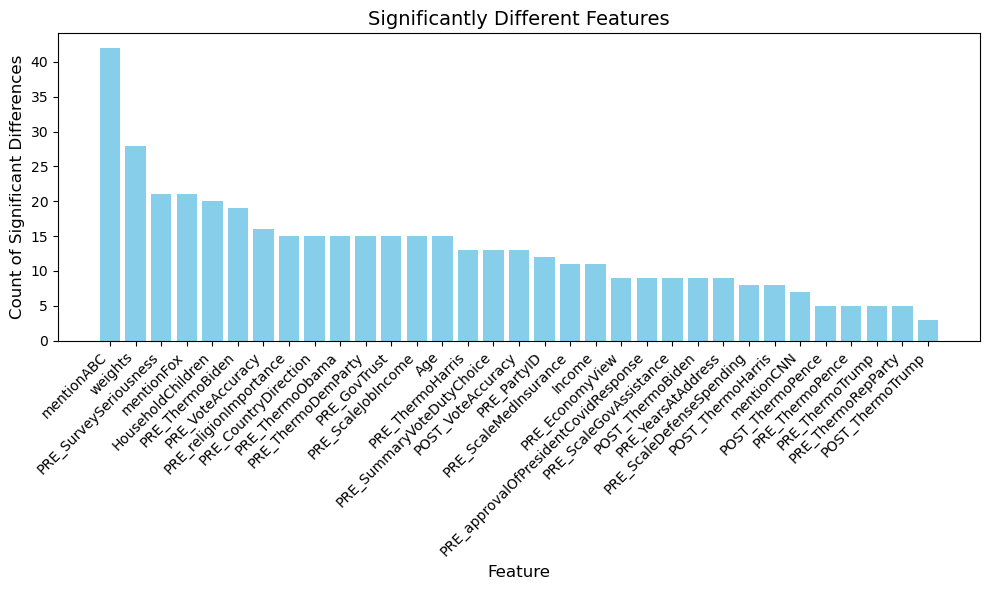

In [48]:
# Separate the feature names and their counts
features, counts = zip(*sorted_feature_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, counts, color='skyblue')

# Adding titles and labels
plt.title('Significantly Different Features', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count of Significant Differences', fontsize=12)

# Rotate feature names if they are too long
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Census

In [49]:
# Standardized Race Labels
RACE_LABELS = {
    1: 'White, non-Hispanic', 
    2: 'Black, non-Hispanic', 
    3: 'Hispanic', 
    4: 'Asian/Pacific Islander, non-Hispanic', 
    5: 'Native American/Alaska Native, non-Hispanic', 
    6: 'Multiple races, non-Hispanic'
}

GENDER_LABELS = {
    1: 'Male', 
    2: 'Female'
}

STATE_MAPPING = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "Washington DC",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode Island",
    45: "South Carolina", 46: "South Dakota", 47: "Tennessee", 48: "Texas",
    49: "Utah", 50: "Vermont", 51: "Virginia", 53: "Washington", 54: "West Virginia",
    55: "Wisconsin", 56: "Wyoming"
}

In [50]:
import pandas as pd
import numpy as np

def preprocess_anes_data(anes_data):
    """
    Preprocess ANES data with standardized labels and compute demographic proportions.
    
    Parameters:
    -----------
    anes_data : pandas.DataFrame
        Raw ANES dataset
    
    Returns:
    --------
    pandas.DataFrame: Processed demographic proportions by state
    """
    # Validate input data
    required_columns = ['Race', 'Sex', 'StateRegistration']
    for col in required_columns:
        if col not in anes_data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Step 1: Standardize Race Labels
    print("\n--- ANES Race Label Mapping ---")
    for original, mapped in RACE_LABELS.items():
        print(f"{original} -> {mapped}")
    anes_data['Race'] = anes_data['Race'].map(RACE_LABELS)
    
    # Verify race mapping
    print("\n--- ANES Race Value Counts After Mapping ---")
    print(anes_data['Race'].value_counts(normalize=True))
    
    # Step 2: Standardize Gender Labels
    anes_data['Sex'] = anes_data['Sex'].map(GENDER_LABELS)
    
    # Step 3: Map State Codes to State Names
    anes_data['StateName'] = anes_data['StateRegistration'].map(STATE_MAPPING)
    
    # Check for missing state names
    missing_states = anes_data['StateName'].isnull().sum()
    if missing_states > 0:
        print(f"Warning: {missing_states} missing state names.")
    
    # Step 4: Calculate Gender Proportions by State
    gender_by_state = anes_data.groupby(['StateName', 'Sex']).size().unstack(fill_value=0)
    gender_proportions = gender_by_state.copy()
    gender_proportions['Female_Prop'] = gender_by_state['Female'] / gender_by_state.sum(axis=1)
    gender_proportions['Male_Prop'] = gender_by_state['Male'] / gender_by_state.sum(axis=1)
    
    # Step 5: Calculate Race Proportions by State
    race_by_state = anes_data.groupby(['StateName', 'Race']).size().unstack(fill_value=0)
    race_proportions = race_by_state.divide(race_by_state.sum(axis=1), axis=0)
    
    # Combine gender and race proportions into a single DataFrame
    proportions = pd.concat([gender_proportions[['Female_Prop', 'Male_Prop']], race_proportions], axis=1)
    
    # Step 6: Add a 'Total' column as the sum of all the categories (e.g., Male, Female, races)
    proportions['Total'] = gender_by_state.sum(axis=1)  # Total number of people per state
    
    # Verify combined proportions with Total column
    print("\n--- ANES Combined Proportions by State (First 5 States) ---")
    print(proportions.head())
    
    return proportions

In [51]:
import pandas as pd
import numpy as np

def preprocess_census_data(data_States):
    """
    Preprocess Census data with standardized labels and compute demographic proportions.
    
    Parameters:
    -----------
    data_States : pandas.DataFrame
        Raw Census dataset
    
    Returns:
    --------
    pandas.DataFrame: Processed demographic proportions by state
    """
    # Create a list to store results
    results = []
    
    # Race mapping to match ANES labels
    race_mapping = {
        'White alone': 'White, non-Hispanic',
        'White non-Hispanic alone': 'White, non-Hispanic',
        'Black alone': 'Black, non-Hispanic',
        'Asian alone': 'Asian/Pacific Islander, non-Hispanic',
        'Hispanic (of any race)': 'Hispanic',
        # Add other mappings as needed
    }
    
    # Print race mapping
    print("\n--- Census Race Label Mapping ---")
    for original, mapped in race_mapping.items():
        print(f"{original} -> {mapped}")
    
    # Get unique states
    states = data_States['Unnamed: 0'].unique()
    states = [state for state in states if state != 'US']
    
    for state in states:
        # Filter rows for this specific state
        state_data = data_States[data_States['Unnamed: 0'] == state]
        
        # Find total population row for the state
        total_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Total']
        
        if not total_row.empty:
            # Total population - convert to numeric, removing commas
            total_population = pd.to_numeric(total_row['Total population'].iloc[0].replace(',', ''), errors='coerce')
            
            # Find Male and Female rows
            male_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Male']
            female_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Female']
            
            # Gender Proportions - convert to numeric
            male_population = pd.to_numeric(male_row['Total population'].iloc[0].replace(',', ''), errors='coerce') if not male_row.empty else np.nan
            female_population = pd.to_numeric(female_row['Total population'].iloc[0].replace(',', ''), errors='coerce') if not female_row.empty else np.nan
            
            male_prop = male_population / total_population if pd.notna(male_population) else np.nan
            female_prop = female_population / total_population if pd.notna(female_population) else np.nan
            
            # Race Proportions with standardized labels
            race_props = {race: 0.0 for race in RACE_LABELS.values()}
            race_counts = {race: 0 for race in RACE_LABELS.values()}  # Track race population counts
            
            for original_race, mapped_race in race_mapping.items():
                race_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == original_race]
                if not race_row.empty:
                    # Convert race population to numeric
                    race_population = pd.to_numeric(race_row['Total population'].iloc[0].replace(',', ''), errors='coerce')
                    race_props[mapped_race] = race_population / total_population if pd.notna(race_population) else 0.0
                    race_counts[mapped_race] = race_population  # Store the actual race population count
            
            # Compile results into a dictionary
            result = {
                'StateName': state,
                'Female_Prop': female_prop,
                'Male_Prop': male_prop,
                **race_props,
                'Total': total_population  # Use the actual total population here
            }
            
            results.append(result)
    
    # Convert results into DataFrame
    proportions_df = pd.DataFrame(results).set_index('StateName')
    
    # Verify the proportions with the Total column
    print("\n--- Census Demographic Proportions by State (First 5 States) ---")
    print(proportions_df.head())
    
    return proportions_df


In [52]:
from statsmodels.stats.proportion import proportions_ztest

def compare_proportions(anes_proportions, census_proportions, alpha=0.05):
    """
    Compare proportions between ANES and Census data using statistical tests.
    
    Parameters:
    -----------
    anes_proportions : pandas.DataFrame
        Proportions from ANES data
    census_proportions : pandas.DataFrame
        Proportions from Census data
    alpha : float, optional
        Significance level for statistical tests (default: 0.05)
    
    Returns:
    --------
    dict: Statistical comparison results
    """
    print("Columns in ANES Data: ", anes_proportions.columns)
    print("Columns in Census Data: ", census_proportions.columns)
    
    # Align the datasets (normalize the column names to match)
    anes_proportions.index = anes_proportions.index.str.upper().str.strip()
    census_proportions.index = census_proportions.index.str.upper().str.strip()
    
    # Now find the common states by checking the intersection of the indices
    common_states = anes_proportions.index.intersection(census_proportions.index)
    print("Number of common states: ", len(common_states))

    comparison_results = {
        'gender': {},
        'race': {}
    }

    significant_differences = []  # List to store statistically significant results
    non_significant_differences = []  # List to store non-significant results
    
    print("\n--- Proportion Comparison Results ---")
    
    # Gender Proportion Comparison
    print("\nGender Proportion Comparison:")
    for state in common_states:
        for demographic in ['Female_Prop', 'Male_Prop']:
            anes_prop = anes_proportions.loc[state, demographic]
            census_prop = census_proportions.loc[state, demographic]
            
            # Get the number of individuals (total population for each demographic)
            anes_count = anes_proportions.loc[state, 'Total']
            census_count = census_proportions.loc[state, 'Total']
            
            # Example logic for calculating successes:
            anes_successes = int(anes_count * anes_prop)  # Convert to integer
            census_successes = int(census_count * census_prop)  # Convert to integer
            
            # Check for zero or invalid counts or successes
            if anes_count == 0 or census_count == 0:
                print(f"Skipping {state} - {demographic} due to zero total count.")
                continue
            if anes_successes == 0 or census_successes == 0:
                print(f"Skipping {state} - {demographic} due to zero successes.")
                continue
            
            # Perform the z-test for proportions
            try:
                z_score, p_value = proportions_ztest(
                    [anes_successes, census_successes], [anes_count, census_count]
                )
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
            except Exception as e:
                print(f"Error calculating z-test for {state} - {demographic}: {e}")
                z_score, p_value = None, None

            result = {
                'anes_prop': anes_prop,
                'census_prop': census_prop,
                'z_score': z_score,
                'p_value': p_value,
                'significant_diff': p_value < alpha if p_value is not None else False
            }
            
            comparison_results['gender'][f"{state}_{demographic}"] = result
            
            # Add to appropriate list based on significance
            if p_value is not None:
                if p_value < alpha:
                    significant_differences.append(f"{state} - {demographic}: Z={z_score:.4f}, p={p_value:.4f}")
                else:
                    non_significant_differences.append(f"{state} - {demographic}: Z={z_score:.4f}, p={p_value:.4f}")
            
            if z_score is not None:
                print(f"{state} - {demographic}:")
                print(f"  ANES: {anes_prop:.4f}, Census: {census_prop:.4f}")
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
                print(f"  Statistically Significant Difference: {p_value < alpha}\n")
            else:
                print(f"  Skipping {state} - {demographic} due to calculation error.\n")
    
    # Race Proportion Comparison
    print("\nRace Proportion Comparison:")
    for state in common_states:
        for race in RACE_LABELS.values():
            anes_prop = anes_proportions.loc[state, race]
            census_prop = census_proportions.loc[state, race]
            
            # Get the number of individuals (total population for each race category)
            anes_count = anes_proportions.loc[state, 'Total']
            census_count = census_proportions.loc[state, 'Total']
            
            # Calculate the number of successes
            anes_successes = int(anes_count * anes_prop)  # Convert to integer
            census_successes = int(census_count * census_prop)  # Convert to integer
            
            # Check for zero or invalid counts or successes
            if anes_count == 0 or census_count == 0:
                print(f"Skipping {state} - {race} due to zero total count.")
                continue
            if anes_successes == 0 or census_successes == 0:
                print(f"Skipping {state} - {race} due to zero successes.")
                continue
            
            # Perform the z-test for proportions
            try:
                z_score, p_value = proportions_ztest(
                    [anes_successes, census_successes], [anes_count, census_count]
                )
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
            except Exception as e:
                print(f"Error calculating z-test for {state} - {race}: {e}")
                z_score, p_value = None, None
            
            result = {
                'anes_prop': anes_prop,
                'census_prop': census_prop,
                'z_score': z_score,
                'p_value': p_value,
                'significant_diff': p_value < alpha if p_value is not None else False
            }
            
            comparison_results['race'][f"{state}_{race}"] = result
            
            # Add to appropriate list based on significance
            if p_value is not None:
                if p_value < alpha:
                    significant_differences.append(f"{state} - {race}: Z={z_score:.4f}, p={p_value:.4f}")
                else:
                    non_significant_differences.append(f"{state} - {race}: Z={z_score:.4f}, p={p_value:.4f}")
            
            if z_score is not None:
                print(f"{state} - {race}:")
                print(f"  ANES: {anes_prop:.4f}, Census: {census_prop:.4f}")
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
                print(f"  Statistically Significant Difference: {p_value < alpha}\n")
            else:
                print(f"  Skipping {state} - {race} due to calculation error.\n")

    # # Print the lists of significant and non-significant differences
    # print("\n--- Statistically Significant Differences ---")
    # for result in significant_differences:
    #     print(result)

    # print("\n--- Statistically Non-Significant Differences ---")
    # for result in non_significant_differences:
    #     print(result)
    
    return comparison_results, significant_differences, non_significant_differences


In [53]:
from statsmodels.stats.proportion import proportions_ztest

# comparison_results

# Main execution
def runComp():
    # Read the datasets
    anes_data = pd.read_csv('anes_data.csv')  # Replace with your ANES data path
    census_data = pd.read_csv(r"../data/Census Data/table04b.csv")  # Replace with your Census data path
    
    # Preprocess ANES data
    processed_anes = preprocess_anes_data(anes_data)
    
    # Preprocess Census data
    census_proportions = preprocess_census_data(census_data)
    
    # Compare proportions
    comparison_results, significant_differences, non_significant_differences  = compare_proportions(processed_anes, census_proportions)
    return significant_differences, non_significant_differences

# Uncomment and run the main function when ready
# if __name__ == '__main__':
#     main()
significant_differences, non_significant_differences = runComp()

# Placeholder print to show the script is complete
print("Demographic Comparison Script Loaded Successfully!")


--- ANES Race Label Mapping ---
1 -> White, non-Hispanic
2 -> Black, non-Hispanic
3 -> Hispanic
4 -> Asian/Pacific Islander, non-Hispanic
5 -> Native American/Alaska Native, non-Hispanic
6 -> Multiple races, non-Hispanic

--- ANES Race Value Counts After Mapping ---
Race
White, non-Hispanic                            0.722101
Hispanic                                       0.095773
Black, non-Hispanic                            0.094203
Asian/Pacific Islander, non-Hispanic           0.034420
Multiple races, non-Hispanic                   0.032729
Native American/Alaska Native, non-Hispanic    0.020773
Name: proportion, dtype: float64

--- ANES Combined Proportions by State (First 5 States) ---
            Female_Prop  Male_Prop  Asian/Pacific Islander, non-Hispanic  \
StateName                                                                  
Alabama        0.653846   0.346154                              0.009615   
Alaska         0.250000   0.750000                              0.000

In [54]:
def process_data(input_list):
    """
    Processes a list of strings to extract the state name, category, Z-score, and p-value.

    Args:
        input_list (list): A list of strings to process.

    Returns:
        list: A list of tuples containing the processed data.
    """

    # List of valid state names
    states = [
        "ALABAMA", "ALASKA", "ARIZONA", "ARKANSAS", "CALIFORNIA", "COLORADO", "CONNECTICUT", "DELAWARE",
        "FLORIDA", "GEORGIA", "HAWAII", "IDAHO", "ILLINOIS", "INDIANA", "IOWA", "KANSAS", "KENTUCKY",
        "LOUISIANA", "MAINE", "MARYLAND", "MASSACHUSETTS", "MICHIGAN", "MINNESOTA", "MISSISSIPPI",
        "MISSOURI", "MONTANA", "NEBRASKA", "NEVADA", "NEW HAMPSHIRE", "NEW JERSEY", "NEW MEXICO",
        "NEW YORK", "NORTH CAROLINA", "NORTH DAKOTA", "OHIO", "OKLAHOMA", "OREGON", "PENNSYLVANIA",
        "RHODE ISLAND", "SOUTH CAROLINA", "SOUTH DAKOTA", "TENNESSEE", "TEXAS", "UTAH", "VERMONT",
        "VIRGINIA", "WASHINGTON", "WEST VIRGINIA", "WISCONSIN", "WYOMING"
    ]
    
    processed_tuples = []
    for entry in input_list:
        # Split the string into components
        components = entry.split()

        # Try to find the longest matching state name
        state = None
        state_end_index = 0
        for i in range(len(components)):
            for j in range(i + 1, len(components) + 1):
                potential_state = " ".join(components[i:j]).replace("-", "").upper()
                if potential_state in states:
                    state = potential_state
                    state_end_index = j
                    break
            if state:
                break

        # If no state is found, skip processing
        if not state:
            continue

        # Extract the category, Z-score, and p-value
        # cateogry should be 1 or 2, ""
        num = 2
        if (len(state.split()) == 2):
            num = 3
        
        category = components[num].replace(":", "")
        z_score = float(components[-2].replace("Z=", "").replace(",", ""))
        p_value = float(components[-1].replace("p=", ""))

        

        # Create a tuple and append it to the list
        processed_tuples.append((state, category, z_score, p_value))

    return processed_tuples

combined = significant_differences + non_significant_differences
processed = process_data(combined)
print(processed)

[('ALABAMA', 'Female_Prop', 2.5425, 0.011), ('ALABAMA', 'Male_Prop', -2.5425, 0.011), ('CALIFORNIA', 'Female_Prop', 2.6208, 0.0088), ('CALIFORNIA', 'Male_Prop', -2.6208, 0.0088), ('NEW JERSEY', 'Female_Prop', 2.187, 0.0287), ('NEW JERSEY', 'Male_Prop', -2.187, 0.0287), ('ARIZONA', 'White,', 5.0004, 0.0), ('ARIZONA', 'Black,', -2.0096, 0.0445), ('ARIZONA', 'Hispanic', -4.2359, 0.0), ('CALIFORNIA', 'White,', 9.2604, 0.0), ('CALIFORNIA', 'Hispanic', -9.4509, 0.0), ('CALIFORNIA', 'Asian/Pacific', -4.242, 0.0), ('COLORADO', 'White,', 1.9605, 0.0499), ('CONNECTICUT', 'Hispanic', -2.6401, 0.0083), ('FLORIDA', 'White,', 4.5348, 0.0), ('FLORIDA', 'Black,', -2.5571, 0.0106), ('FLORIDA', 'Hispanic', -5.519, 0.0), ('GEORGIA', 'Black,', -2.1139, 0.0345), ('HAWAII', 'White,', 3.3696, 0.0008), ('ILLINOIS', 'White,', 3.4081, 0.0007), ('ILLINOIS', 'Hispanic', -3.2539, 0.0011), ('ILLINOIS', 'Asian/Pacific', -2.1649, 0.0304), ('LOUISIANA', 'White,', 2.085, 0.0371), ('LOUISIANA', 'Black,', -2.6799, 0.0074

In [55]:
from collections import defaultdict

# Dictionary to store combined z-scores per state
state_z_scores = defaultdict(float)

# Process data
for entry in processed:
    # Handle multi-word state names
    if len(entry) == 4:
        state = entry[0]
        z_score = entry[2]
    elif len(entry) == 5:
        state = f"{entry[0]} {entry[1]}"
        z_score = entry[3]
    else:
        continue

    # Add absolute z-score to the state's total
    state_z_scores[state] += abs(z_score)

# Convert defaultdict to a regular dictionary and sort for readability
state_z_scores = dict(sorted(state_z_scores.items(), key=lambda x: -x[1]))

# Display the results
print(state_z_scores)


{'CALIFORNIA': 28.715600000000002, 'NEW MEXICO': 21.4415, 'NEW YORK': 16.6327, 'FLORIDA': 16.2938, 'TEXAS': 15.491700000000002, 'NORTH CAROLINA': 15.036399999999999, 'ARIZONA': 13.2345, 'NEW JERSEY': 13.1992, 'VIRGINIA': 12.039000000000001, 'PENNSYLVANIA': 11.2125, 'ILLINOIS': 10.653800000000002, 'MAINE': 10.2011, 'WASHINGTON': 10.1791, 'VERMONT': 9.9726, 'MONTANA': 9.9196, 'MARYLAND': 9.8614, 'MASSACHUSETTS': 9.7382, 'CONNECTICUT': 9.698500000000001, 'TENNESSEE': 9.6393, 'COLORADO': 9.629400000000002, 'NORTH DAKOTA': 9.5107, 'NEW HAMPSHIRE': 8.899999999999999, 'LOUISIANA': 8.802100000000001, 'GEORGIA': 8.5295, 'RHODE ISLAND': 8.2401, 'KANSAS': 7.9513, 'ALABAMA': 7.926000000000001, 'WISCONSIN': 7.7888, 'NEVADA': 6.7501, 'OHIO': 6.3251, 'OREGON': 6.237799999999999, 'WEST VIRGINIA': 6.0515, 'UTAH': 5.950399999999999, 'MICHIGAN': 5.8877999999999995, 'MISSOURI': 5.688000000000001, 'SOUTH DAKOTA': 5.5273, 'MISSISSIPPI': 5.3951, 'ARKANSAS': 5.1738, 'HAWAII': 5.0302, 'IDAHO': 4.43199999999999

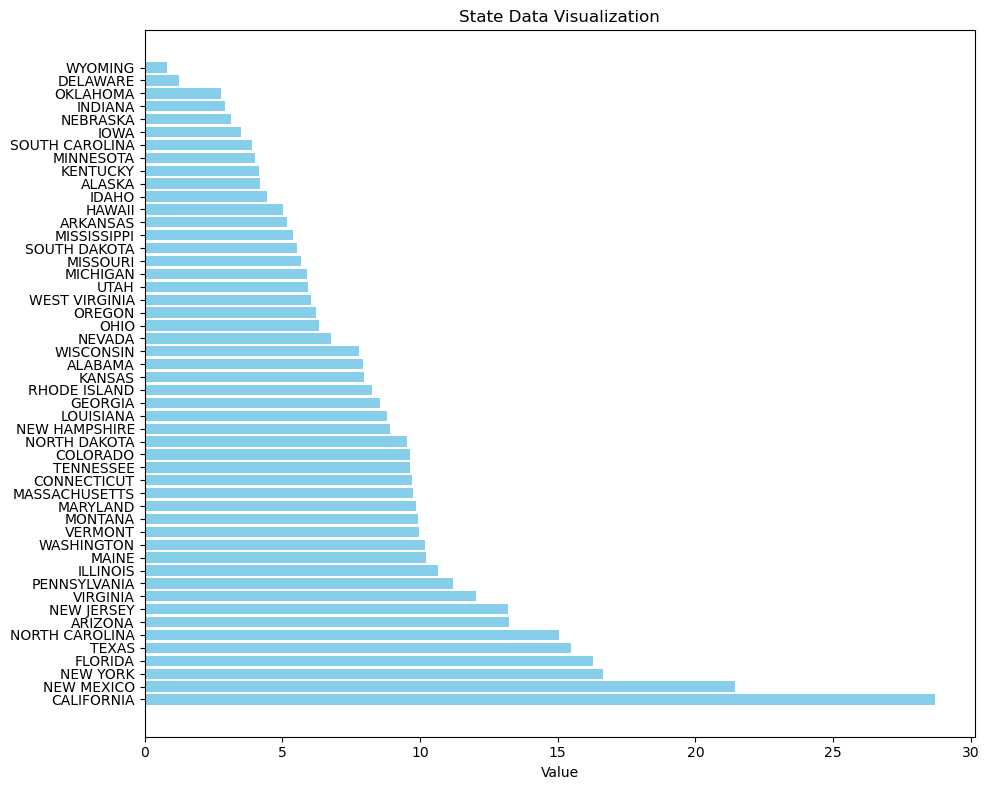

In [56]:
# Extracting states and their respective values
states = list(state_z_scores.keys())
values = list(state_z_scores.values())

# Plotting the bar graph
plt.figure(figsize=(10, 8))
plt.barh(states, values, color='skyblue')
plt.xlabel('Value')
plt.title('State Data Visualization')

# To make the y-axis labels more readable
plt.tight_layout()

# Show the plot
plt.show()